# Let's make a log of the LUH16AB Binary components

| BTJD | Binary Component | Nod position| TESS Flux|
|--|--|--| -- |
|x | A | A | -- |
|y| B | A| -- |

The header info in the IGRINS Slit Viewing Camera was malformed.  Let's attempt to fix it so we can preserve our nice figures.

In [1]:
import lightkurve as lk

In [2]:
lk.__version__

'2.0.10'

In [3]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import sys
import os

In [5]:
import aplpy

In [6]:
aplpy.__version__

'2.0.3'

In [7]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import (PercentileInterval, SqrtStretch,
                                   ImageNormalize)
from astropy.io import fits
from astropy.wcs import WCS
import montage_wrapper as montage

In [8]:
from reproject import reproject_interp, reproject_exact

In [9]:
pos = SkyCoord(ra='10 49 11.95', dec='-53 19 01.8', unit=(u.hourangle, u.deg), frame='icrs')

### What imaging do we want?

In [10]:
rad_value = 60
rad = rad_value*u.arcsecond
diam = rad_value*2

In [11]:
def make_postage_stamp(im_in, output, hdu=None, vmin=None, vmax=None, radius=None):
    '''Make a postage stamp image'''
    fig = plt.figure(figsize=(5,5))
    if radius is None:
        radius = 60 * u.arcsecond
    if hdu is None:
        mosaic = aplpy.FITSFigure(im_in, north=True, figure = fig)
    else:
        mosaic = aplpy.FITSFigure(im_in,hdu=hdu, north=True, figure = fig)
    mosaic.recenter(pos.ra,pos.dec, radius=radius.to(u.degree).value)  # degrees
    if (vmin is not None) & (vmax is not None):
        mosaic.show_grayscale(invert=True, interpolation='none', stretch='log',
                              vmin=vmin, vmax=vmax)
        mosaic.show_grayscale(invert=True, interpolation='none', stretch='log',
                              vmin=vmin, vmax=vmax)        
    else:
        mosaic.show_grayscale(invert=True, interpolation='none', stretch='log')
        mosaic.show_grayscale(invert=True, interpolation='none', stretch='log')
    mosaic.tick_labels.set_font(size='small')
    #mosaic.tick_labels.set_xformat("hh:mm:ss")
    mosaic.set_theme('paper')

    aplpy.AxisLabels(mosaic).hide()
    aplpy.TickLabels(mosaic).hide()

    mosaic.add_scalebar(10.0 * u.arcsecond)
    #fig.scalebar.show(1.0/3600.0*4.0)  # length in degrees
    #mosaic.scalebar.set_length(4.0 * u.arcsecond)
    mosaic.scalebar.set_label("$10^{\prime\prime}$")
    #mosaic.scalebar.set_corner('bottom right')
    mosaic.scalebar.set_color('red')
    mosaic.scalebar.set_linestyle('solid')
    mosaic.scalebar.set_linewidth(5)  # points
    mosaic.scalebar.set_font(size=12, weight='medium', \
                          stretch='normal', family='sans-serif', \
                          style='normal', variant='normal')

    mosaic.save(output, dpi=300)

### IGRINS Slit Viewing Camera

In [12]:
rad_value = 21
rad = rad_value*u.arcsecond
diam = rad_value*2

In [13]:
import glob

In [14]:
fns = sorted(glob.glob('../../data/IGRINS/originals/GS-2021A-DD-104/**/SDCS*.fits'))

In [15]:
fn = fns[0]
hdu = fits.open(fn)

In [16]:
im_in = hdu
output = 'Luhman16_{}x{}arcsec_IGRINS_20210311.png'.format(diam, diam)

In [17]:
hdu[1].header['CROTA1'] += 90
hdu[1].header['CROTA2'] += 90

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


CPU times: user 5.37 s, sys: 464 ms, total: 5.83 s
Wall time: 5.83 s


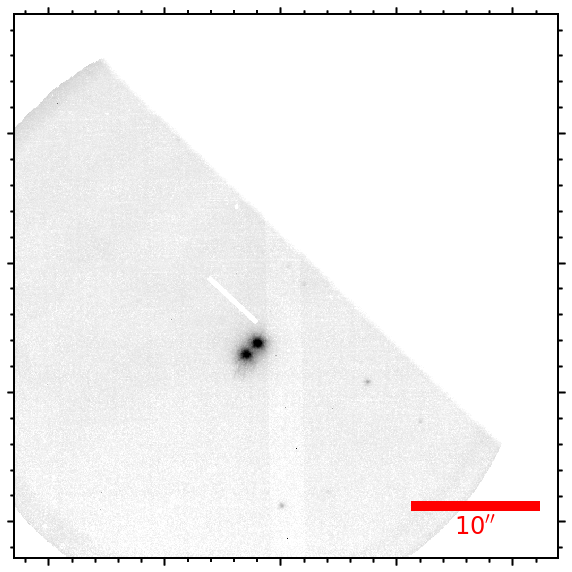

In [18]:
%%time
make_postage_stamp(im_in, output, hdu=1, vmin=150, vmax=6000, radius=rad)

In [19]:
keep_keywords = ['MJD-OBS', 'TELRA', 'TELDEC', 'AMSTART']

In [20]:
def get_header_info(fn, ext=1):
    df_out = pd.DataFrame()
    hdu = fits.open(fn)
    hdr = hdu[ext].header
    return {key:hdr[key] for key in keep_keywords}

In [21]:
df_log = pd.DataFrame()
for i, fn in enumerate(fns):
    df = pd.DataFrame(get_header_info(fn), index=[i])
    basename = os.path.basename(fn)
    df['fn'] = basename
    df_log = df_log.append(df)

In [22]:
df_log.to_excel('../../data/IGRINS/SVC_log_original.xlsx') # We changed the name of the labelled one.

Now we have to hand-label the components and nods with human visual inspection.

## Okay, now read in that labelled sheet

In [23]:
df_labelled = pd.read_csv('../../data/IGRINS/SVC_log_labelled_csv.csv')
df_labelled = df_labelled.drop(columns=[df_labelled.columns[0]])

Yay! Let's read in the headers of the spectra.

## Spectra log

In [24]:
keep_keywords = ['MJD-OBS', 'TELRA', 'TELDEC', 'AMSTART', 'OBJECT']

In [25]:
fns = sorted(glob.glob('../../data/IGRINS/originals/GS-2021A-DD-104/**/SDCH*.fits'))

In [26]:
df_log_spec = pd.DataFrame()
for i, fn in enumerate(fns):
    df = pd.DataFrame(get_header_info(fn, ext=0), index=[i])
    basename = os.path.basename(fn)
    df['fn'] = basename
    df_log_spec = df_log_spec.append(df)

In [27]:
pd.options.display.max_rows = 999

In [28]:
df_join = pd.concat([df_labelled, df_log_spec], axis=0, ignore_index=True)

Awesome! I just spot-checked the table and it will totally work.  Let's apply some pandas manipulation to condense the table into a publishable product.

In [29]:
df_join = df_join.sort_values('MJD-OBS').reset_index(drop=True)

In [30]:
from astropy.time import Time

In [31]:
df_join['BTJD'] = Time(df_join['MJD-OBS'], format='mjd').btjd

In [32]:
df_join = df_join.drop(columns=['MJD-OBS', 'TELRA', 'TELDEC', 'AMSTART', 'On Slit'])

Transfer the target labels from surrounding SVC images that were inspected by eye.

In [33]:
df_join = df_join.bfill()

In [34]:
df_join = df_join[df_join.fn.str.contains('SDCH')]

In [35]:
df_join['Night'] = df_join.fn.str.split('_').apply(lambda x: x[1])

In [36]:
df_join['File'] = df_join.fn.str.split('_').apply(lambda x: x[2]).str.split('.fits').apply(lambda x: x[0])

In [37]:
cols = ['Night','Binary Component','File', 'Nod Position', 'BTJD',]

In [38]:
df_join = df_join[cols]

In [39]:
df_join.set_index(['Night', 'Binary Component'])

File Nod Position         BTJD
Night    Binary Component                                
20210311 A                 0021            A  2285.637575
         A                 0022            B  2285.640007
         A                 0023            B  2285.642180
         A                 0024            A  2285.644333
         B                 0025            A  2285.649268
         B                 0026            B  2285.651431
         B                 0027            B  2285.653597
         B                 0028            A  2285.655747
20210312 A                 0090            A  2286.746485
         A                 0091            B  2286.748670
         A                 0092            B  2286.750831
         A                 0093            A  2286.752991
         B                 0094            A  2286.756637
         B                 0095            B  2286.758802
         B                 0096            B  2286.760957
         B                 0097            A  2286.763112
20210313 A                 0021            A  2287.653320
         A                 0022            B  2287.655483
         A                 0023            B  2287.657629
         A                 0024            A  2287.659791
         B                 0025            A  2287.671161
         B                 0026            B  2287.673337
         B                 0027            B  2287.675514
         B                 0028            A  2287.677672
20210317 A                 0051            A  2291.799715
         A                 0052            B  2291.801890
         B                 0053            A  2291.808620
         B                 0054            B  2291.810781

In [40]:
df_final = df_join.set_index(['Night', 'File']).groupby(['Night', 'Binary Component']).BTJD.mean().to_frame()

In [52]:
print(df_final.to_latex(header=True))

\begin{tabular}{llr}
\toprule
         &   &         BTJD \\
Night & Binary Component &              \\
\midrule
20210311 & A &  2285.641024 \\
         & B &  2285.652511 \\
20210312 & A &  2286.749744 \\
         & B &  2286.759877 \\
20210313 & A &  2287.656556 \\
         & B &  2287.674421 \\
20210317 & A &  2291.800803 \\
         & B &  2291.809701 \\
\bottomrule
\end{tabular}



Let's trim the table to just the contents so that we can use the ApJ table header.

In [59]:
lines = df_final.to_latex(header=True).split('\n')[5:-3]
output = ''
for line in lines:
    output += (line + '\n')

In [ ]:
print(output)

In [62]:
with open('../../document/paper1/IGRINS_obs_log.txt', 'w') as f:
    f.write(output)

### The end!